In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np
import random
import re
import nltk
nltk.download('punkt')

class SkipGramDataset(Dataset):
    def __init__(self, tokens, word_to_ix, negative_sample_size=5, window_size=5):
        self.tokens = tokens
        self.word_to_ix = word_to_ix
        self.vocab_size = len(word_to_ix)
        self.negative_sample_size = negative_sample_size
        self.window_size = window_size
        self.pairs = self.generate_pairs(tokens, window_size)

    def generate_pairs(self, tokens, window_size):
        pairs = []
        for i, token in enumerate(tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, len(tokens))):
                if i != j:
                    pairs.append((self.word_to_ix[token], self.word_to_ix[tokens[j]]))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        negative_samples = torch.randint(0, self.vocab_size, (self.negative_sample_size,))
        return center, context, negative_samples

with open('/content/advs.txt', 'r', encoding='utf-8') as file:
    text = file.read().lower()
text = re.sub(f'[{string.punctuation}]', '', text)
tokens = word_tokenize(text)
word_freq = Counter(tokens)
vocab = {word: i for i, word in enumerate(word_freq)}
dataset = SkipGramDataset(tokens, vocab)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dims):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dims)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dims)

    def forward(self, center, context, negative_samples):
        center_embed = self.embeddings(center)
        context_embed = self.context_embeddings(context)
        negative_embed = self.context_embeddings(negative_samples)

        positive_score = torch.bmm(center_embed.unsqueeze(1), context_embed.unsqueeze(2)).squeeze()
        negative_score = torch.bmm(negative_embed, center_embed.unsqueeze(2)).squeeze()

        positive_loss = -torch.log(torch.sigmoid(positive_score) + 1e-9)
        negative_loss = -torch.sum(torch.log(torch.sigmoid(-negative_score) + 1e-9), dim=1)

        return (positive_loss + negative_loss).mean()


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dims = 300
vocab_size = len(vocab)
model = SkipGramModel(vocab_size, embedding_dims).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

model.train()
epochs = 30
for epoch in range(epochs):
    total_loss = 0
    for center, context, negative_samples in dataloader:
        center, context, negative_samples = center.to(device), context.to(device), negative_samples.to(device)

        optimizer.zero_grad()
        loss = model(center, context, negative_samples)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")


Epoch 1, Loss: 6.9325348248453755
Epoch 2, Loss: 1.922452527716202
Epoch 3, Loss: 1.4537715150185526
Epoch 4, Loss: 1.2577840696342304
Epoch 5, Loss: 1.174363582334873
Epoch 6, Loss: 1.1265566641220608
Epoch 7, Loss: 1.09666593305752
Epoch 8, Loss: 1.0673847446936218
Epoch 9, Loss: 1.0493195338025252
Epoch 10, Loss: 1.03295322103743
Epoch 11, Loss: 1.0207626981744562
Epoch 12, Loss: 1.0094034178382962
Epoch 13, Loss: 1.0008910657608345
Epoch 14, Loss: 0.9949054019908382
Epoch 15, Loss: 0.9894118854327678
Epoch 16, Loss: 0.9860146573495026
Epoch 17, Loss: 0.9821805401091006
Epoch 18, Loss: 0.9788574726264304
Epoch 19, Loss: 0.9798148177024669
Epoch 20, Loss: 0.9754166712149716
Epoch 21, Loss: 0.9723657136910582
Epoch 22, Loss: 0.9714847095091982
Epoch 23, Loss: 0.9689834684191851
Epoch 24, Loss: 0.9698956872968991
Epoch 25, Loss: 0.9667698285467704
Epoch 26, Loss: 0.9660160680922977
Epoch 27, Loss: 0.9653788393257648
Epoch 28, Loss: 0.9635216787369983
Epoch 29, Loss: 0.9660779353223902


In [24]:
def get_embedding(word, model, word_to_ix):
    index = torch.tensor([word_to_ix[word]], device=device)
    return model.embeddings(index).squeeze().detach()

def dot_product_similarity(a, b):
    return torch.dot(a, b)

king_vec = get_embedding('king', model, vocab)
man_vec = get_embedding('man', model, vocab)
woman_vec = get_embedding('woman', model, vocab)
queen_vec = get_embedding('queen', model, vocab)

result_vec = king_vec - man_vec + woman_vec

similarity = dot_product_similarity(result_vec, queen_vec)
print(f"Dot product similarity with 'queen': {similarity.item()}")

Dot product similarity with 'queen': 30.869813919067383


In [25]:
similarity_scores = {}
for word, idx in vocab.items():
    if word in ['king', 'man', 'woman', 'queen']: continue  # Skip the words used in the analogy
    other_vec = get_embedding(word, model, vocab).squeeze()
    similarity_scores[word] = dot_product_similarity(result_vec, other_vec).item()

sorted_similarities = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
print("Top 10 similar words to 'king - man + woman':")
for word, score in sorted_similarities[:10]:
    print(f"{word}: {score}")


Top 10 similar words to 'king - man + woman':
unravelling: 56.804195404052734
denying: 56.799461364746094
womanoh: 56.29860305786133
bodes: 56.25878143310547
grand: 55.94200134277344
stevenson: 55.15856170654297
proposition: 54.86300277709961
hoarsely: 53.66973876953125
amazement: 53.335914611816406
rejoin: 53.324527740478516


Modified Model

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

class SkipGramModelEnhanced(nn.Module):
    def __init__(self, vocab_size, embedding_dims):
        super(SkipGramModelEnhanced, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dims)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dims)
        self.linear = nn.Linear(embedding_dims, embedding_dims, bias=False)

    def forward(self, center, context, negative_samples):
        center_embed = self.embeddings(center)
        context_embed = self.context_embeddings(context)
        negative_embed = self.context_embeddings(negative_samples)

        center_embed = torch.relu(self.linear(center_embed))
        context_embed = torch.relu(self.linear(context_embed))
        negative_embed = torch.relu(self.linear(negative_embed))

        positive_score = torch.bmm(center_embed.unsqueeze(1), context_embed.unsqueeze(2)).squeeze()
        negative_score = torch.bmm(negative_embed, center_embed.unsqueeze(2)).squeeze()

        positive_loss = -torch.log(torch.sigmoid(positive_score) + 1e-9)
        negative_loss = -torch.sum(torch.log(torch.sigmoid(-negative_score) + 1e-9), dim=1)

        return (positive_loss + negative_loss).mean()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dims = 200
vocab_size = len(vocab)
model = SkipGramModelEnhanced(vocab_size, embedding_dims).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

model.train()
epochs = 30
for epoch in range(epochs):
    total_loss = 0
    for center, context, negative_samples in dataloader:  # Ensure dataloader is defined as before
        center, context, negative_samples = center.to(device), context.to(device), negative_samples.to(device)

        optimizer.zero_grad()
        loss = model(center, context, negative_samples)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

Epoch 1, Loss: 4.2371718650228125
Epoch 2, Loss: 3.917842842128179
Epoch 3, Loss: 3.903478750977264
Epoch 4, Loss: 3.900227931614258
Epoch 5, Loss: 3.8972263630122352
Epoch 6, Loss: 3.8956638418298413
Epoch 7, Loss: 3.895285958179989
Epoch 8, Loss: 3.8951068815653103
Epoch 9, Loss: 3.8930714408012284
Epoch 10, Loss: 3.893043732689785
Epoch 11, Loss: 3.8921116665151487
Epoch 12, Loss: 3.8926752469777592
Epoch 13, Loss: 3.8921729820815085
Epoch 14, Loss: 3.8913062388649657
Epoch 15, Loss: 3.8915063264085354
Epoch 16, Loss: 3.891020587279139
Epoch 17, Loss: 3.890424474344795
Epoch 18, Loss: 3.8913545102289278
Epoch 19, Loss: 3.890477205442589
Epoch 20, Loss: 3.890321330548266
Epoch 21, Loss: 3.889993067823511
Epoch 22, Loss: 3.8893055274295247
Epoch 23, Loss: 3.890253669361779
Epoch 24, Loss: 3.8899526206481245
Epoch 25, Loss: 3.8896628949506877
Epoch 26, Loss: 3.8895890701073723
Epoch 27, Loss: 3.88970651318649
Epoch 28, Loss: 3.8893710577791216
Epoch 29, Loss: 3.890175323896912
Epoch 30

In [30]:
def get_embedding(word, model, word_to_ix):
    index = torch.tensor([word_to_ix[word]], device=device)
    return model.embeddings(index).squeeze().detach()

def dot_product_similarity(a, b):
    return torch.dot(a, b)

king_vec = get_embedding('king', model, vocab)
man_vec = get_embedding('man', model, vocab)
woman_vec = get_embedding('woman', model, vocab)
queen_vec = get_embedding('queen', model, vocab)

result_vec = king_vec - man_vec + woman_vec

similarity = dot_product_similarity(result_vec, queen_vec)
print(f"Dot product similarity with 'queen': {similarity.item()}")

Dot product similarity with 'queen': 119.6663589477539


In [34]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def get_embedding(word, model, word_to_ix):
    index = torch.tensor([word_to_ix[word]], device=device)
    return model.embeddings(index).squeeze().detach().cpu().numpy()

words = ['brother', 'sister', 'uncle', 'aunt']
embeddings = np.array([get_embedding(word, model, vocab) for word in words])

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
word_to_pca = {word: reduced_embeddings[i] for i, word in enumerate(words)}

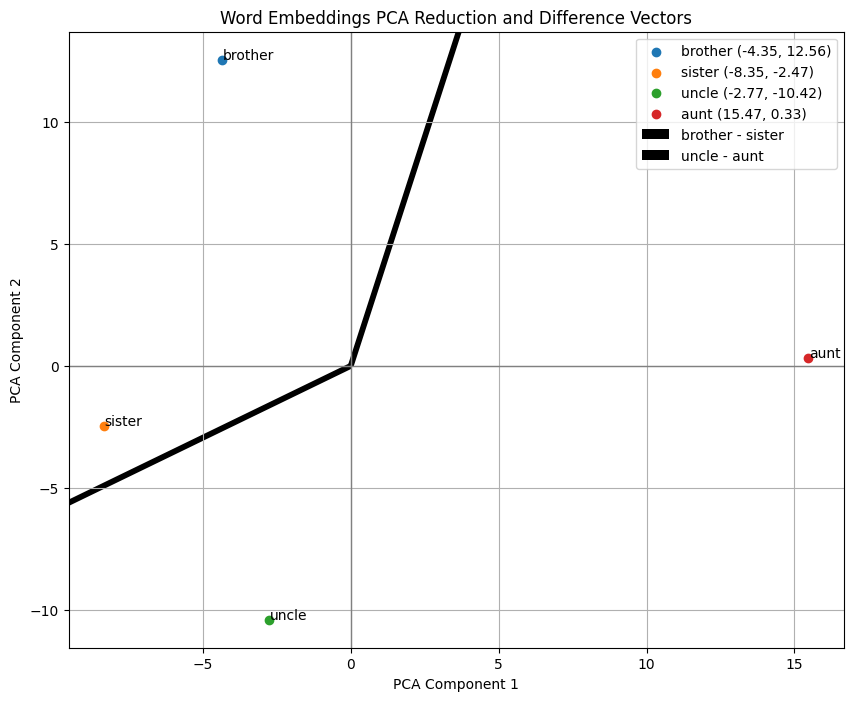

In [35]:
vectors_to_visualize = {
    'brother - sister': word_to_pca['brother'] - word_to_pca['sister'],
    'uncle - aunt': word_to_pca['uncle'] - word_to_pca['aunt']
}

plt.figure(figsize=(10, 8))

for word, (x, y) in word_to_pca.items():
    plt.scatter(x, y, label=f'{word} ({x:.2f}, {y:.2f})')
    plt.text(x + 0.02, y + 0.02, word)

for label, vec in vectors_to_visualize.items():
    plt.quiver(0, 0, vec[0], vec[1], scale=1, scale_units='xy', angles='xy', label=label)

plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Word Embeddings PCA Reduction and Difference Vectors")
plt.legend()
plt.show()